In [32]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import scipy.special as special
from scipy.stats import poisson, uniform, norm
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from mpl_axes_aligner import align

import wf_func as wff

plt.rcParams['font.size'] = 20

import matplotlib
matplotlib.use('Agg')
%matplotlib inline

In [33]:
def my_cmap():
    plasma = cm.get_cmap('plasma', 65536)
    newcolors = plasma(np.linspace(0, 1, 65536))
    white = np.array([65535/65536, 65535/65536, 65535/65536, 1])
    newcolors[:1, :] = white
    newcmp = ListedColormap(newcolors)
    return newcmp

# 模拟中的时间分布

In [36]:
# methods = ['lucyddm', 'xiaopeip', 'takara', 'mcmcrec']
methods = ['lucyddm', 'fbmp']

para = '20-00-10'
Tau = 0; Sigma = 10
wf = h5py.File('waveform/' + para + '.h5', 'r', libver='latest', swmr=True)
spe_pre = wff.read_model('spe.h5')
p = spe_pre[0]['parameters']
mycmp = my_cmap()
colors = {'truth':'k', 'lucyddm':'g', 'xiaopeip':'b', 'takara':'y', 'mcmcrec':'r', 'fbmp':'m'}
t0 = wf['SimTruth/T']
pelist = wf['SimTriggerInfo/PEList']
wave = wf['Readout/Waveform']

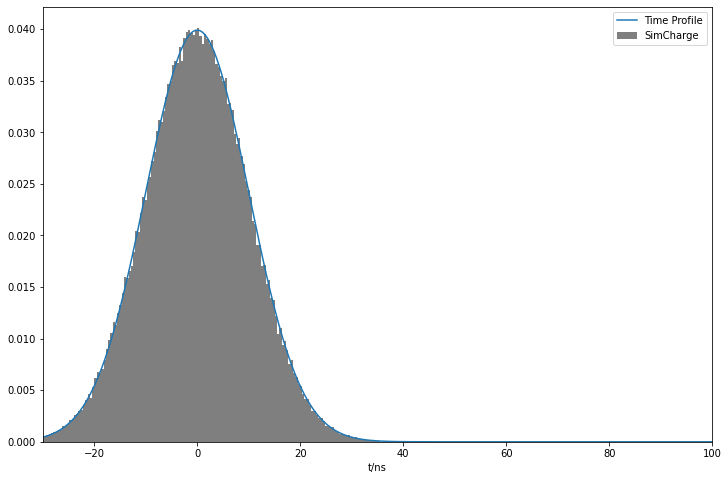

In [37]:
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
t = np.arange(-40, 120, 0.1)
ax.plot(t, wff.convolve_exp_norm(t, Tau, Sigma), label='Time Profile')
ax.hist(pelist['HitPosInWindow'] - np.repeat(t0['T0'], np.unique(pelist['TriggerNo'], return_counts=True)[1]), bins=200, alpha=0.5, label='SimCharge', density=True, color=colors['truth'])
ax.set_xlim(-30, 100)
ax.legend()
ax.set_xlabel('t/ns')
plt.show()

# 模拟中的电荷分布

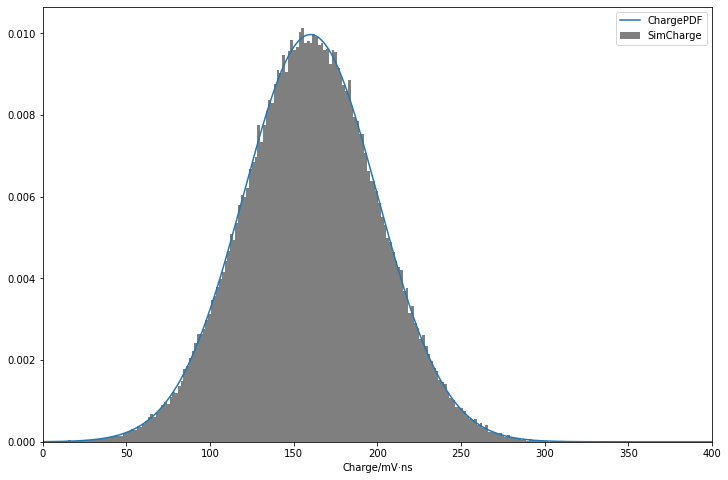

In [38]:
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
t = np.arange(0, 1000, 0.1)
ax.plot(t, norm.pdf(t, loc=160., scale=40.) / (1 - norm.cdf(0, loc=160., scale=40.)), label='ChargePDF')
ax.hist(pelist['Charge'], bins=200, alpha=0.5, label='SimCharge', density=True, color=colors['truth'])
ax.set_xlim(0, 400)
ax.legend()
ax.set_xlabel('Charge/mV·ns')
plt.show()

# 重建结果的时间分布

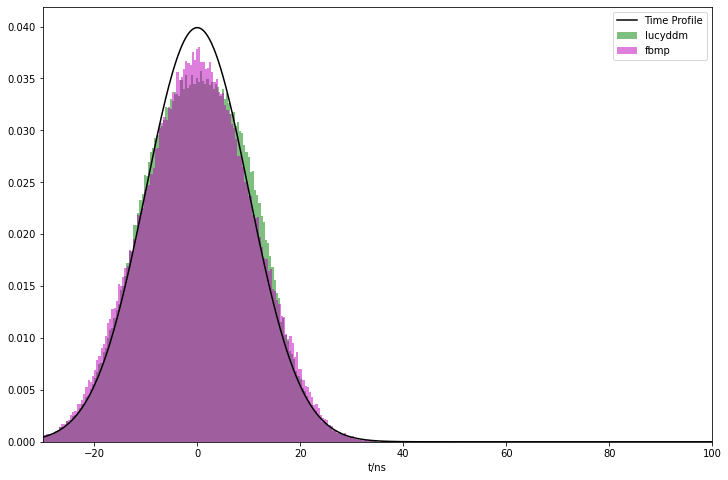

In [39]:
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
t = np.arange(-40, 120, 0.1)
ax.plot(t, wff.convolve_exp_norm(t, Tau, Sigma), label='Time Profile', color=colors['truth'])
for m in methods:
    so = h5py.File('result/' + m + '/solu/' + para + '.h5', 'r', libver='latest', swmr=True)
    ch = h5py.File('result/' + m + '/char/' + para + '.h5', 'r', libver='latest', swmr=True)
    solut0 = so['starttime']
    chargepelist = ch['photoelectron']
    ax.hist(chargepelist['HitPosInWindow'] - np.repeat(solut0['tscharge'], np.unique(chargepelist['TriggerNo'], return_counts=True)[1]), bins=200, alpha=0.5, label=m, density=True, color=colors[m])
ax.set_xlim(-30, 100)
ax.legend()
ax.set_xlabel('t/ns')
plt.show()

# 重建结果的电荷分布

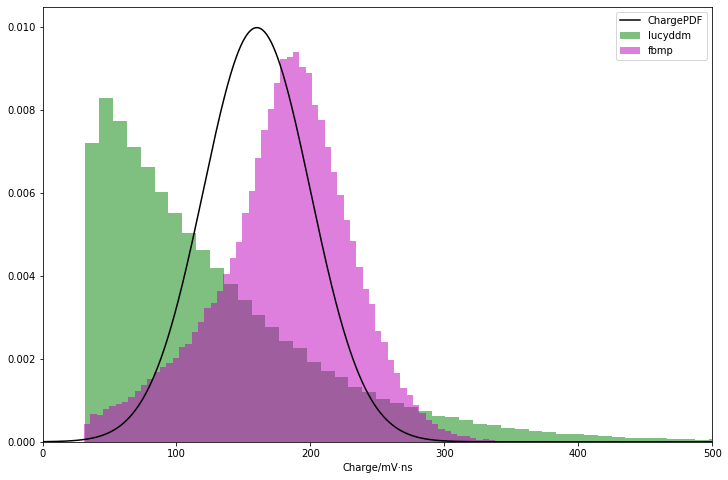

In [40]:
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
t = np.arange(0, 1000, 0.1)
ax.plot(t, norm.pdf(t, loc=160., scale=40.) / (1 - norm.cdf(0, loc=160., scale=40.)), label='ChargePDF', color=colors['truth'])
for m in methods:
    ch = h5py.File('result/' + m + '/char/' + para + '.h5', 'r', libver='latest', swmr=True)
    ax.hist(ch['photoelectron']['Charge'], bins=100, alpha=0.5, label=m, density=True, color=colors[m])
ax.set_xlim(0, 500)
ax.legend()
ax.set_xlabel('Charge/mV·ns')
plt.show()

# 单事例分析

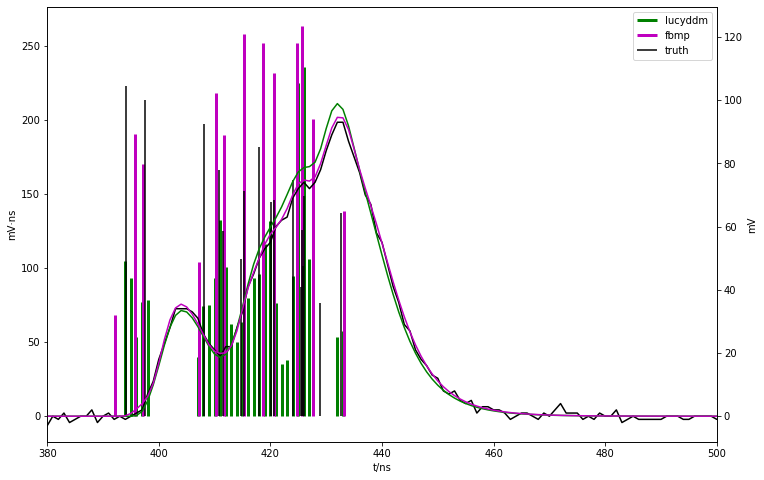

In [43]:
i = 0
pan = np.arange(len(wave[i]['Waveform']))
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
truth = pelist[pelist['TriggerNo'] == i]
ax2 = ax.twinx()
ax2.plot(wave[i]['Waveform'], color=colors['truth'])
for m, mi in zip(methods, list(range(len(m)))):
    ch = h5py.File('result/' + m + '/char/' + para + '.h5', 'r', libver='latest', swmr=True)
    charge = ch['photoelectron'][ch['photoelectron']['TriggerNo'] == i]
    wav_sub = np.sum([np.where(pan > charge['HitPosInWindow'][j], wff.spe(pan - charge['HitPosInWindow'][j], tau=p[0], sigma=p[1], A=p[2]) * charge['Charge'][j], 0) for j in range(len(charge['HitPosInWindow']))], axis=0) / np.sum(spe_pre[0]['spe'])
    ax.vlines(charge['HitPosInWindow']+mi/5, ymin=0, ymax=charge['Charge'], label=m, color=colors[m], linewidth=3)
    ax2.plot(wav_sub, color=colors[m])
ax.vlines(truth['HitPosInWindow'], ymin=0, ymax=truth['Charge'], label='truth', color=colors['truth'])
ax.set_xlim(380, 500)
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)
align.yaxes(ax, 0, ax2, 0)
ax.set_xlabel('t/ns')
ax.set_ylabel('mV·ns')
ax2.set_ylabel('mV')
plt.show()

# 探索 MCMC 针对稀疏参数的优化方法

100%|██████████| 10000/10000 [00:06<00:00, 1550.89it/s]


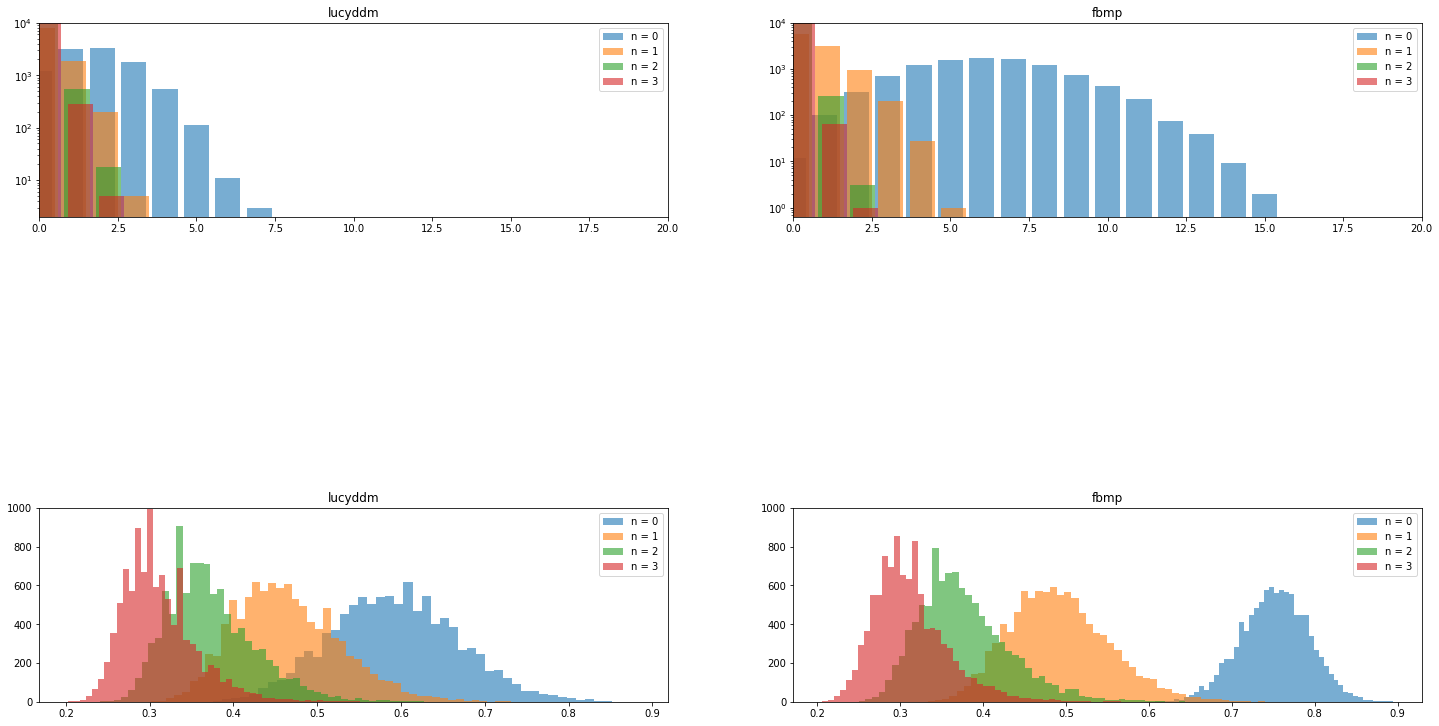

In [46]:
plt.close()
fig = plt.figure(figsize=(24, 16))
for m, mi in zip(methods, list(range(len(m)))):
    ch = h5py.File('result/' + m + '/char/' + para + '.h5', 'r', libver='latest', swmr=True)
    chargepelist = ch['photoelectron']
    e_tru, i_tru = np.unique(pelist['TriggerNo'], return_index=True)
    i_tru = np.append(i_tru, len(pelist))
    e_cha, i_cha = np.unique(chargepelist['TriggerNo'], return_index=True)
    i_cha = np.append(i_cha, len(chargepelist))
    gs = gridspec.GridSpec(4, 2, figure=fig, left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.2, hspace=0.25)
    ax1 = fig.add_subplot(gs[mi // 2, mi % 2])
    ax2 = fig.add_subplot(gs[mi // 2+2, mi % 2])
    for n in [0, 1, 2, 3]:
        s = np.empty(len(wave))
        oldl = np.empty(len(wave))
        newl = np.empty(len(wave))
        for i in tqdm(range(len(wave))):
            truthlisti = pelist[i_tru[i]:i_tru[i+1]]
            chargelisti = chargepelist[i_cha[i]:i_cha[i+1]]
            truthhit = np.unique(np.floor(truthlisti['HitPosInWindow']))
            aug_chargelisti = np.hstack(chargelisti['HitPosInWindow'][:, None] + np.arange(-n, n+1))
            chargehit = np.unique(np.floor(aug_chargelisti))
            s[i] = len(truthhit) - np.sum(np.isin(truthhit, chargehit))
#             s[i] = np.min(np.abs(truthhit[:, None] - chargehit), axis=1).sum()
            oldl[i] = np.clip(chargelisti['HitPosInWindow'].max() + round(3 * spe_pre[0]['mar_l']), 0, 1029) - np.clip(chargelisti['HitPosInWindow'].min() - round(3 * spe_pre[0]['mar_l']), 0, 1029)
            newl[i] = len(chargehit)
        di, ci = np.unique(s, return_counts=True)
        ax1.bar(di + n/10, ci, label='n = {}'.format(n), alpha=0.6)
#         di, ci = np.unique(oldl - newl, return_counts=True)
#         ax2.bar(di + n/10, ci, label='n = {}'.format(n), alpha=0.6)
        ax2.hist(1 - newl / oldl, bins=50, label='n = {}'.format(n), alpha=0.6)
    ax1.legend()
    ax1.set_yscale('log')
    ax1.set_title(m)
    ax1.set_ylim(top=1e4)
    ax1.set_xlim(0, 20)
    ax2.legend()
    ax2.set_title(m)
    ax2.set_ylim(top=1e3)
plt.savefig('op.png')